In [41]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated, List
from dotenv import load_dotenv
import os

In [42]:
load_dotenv()
openai_model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")

In [56]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=5)
# tool = TavilySearchResults(max_results=1)
# tool.invoke("LangGraph에서 '노드'란 무엇인가요?")
tool.invoke("What is LangGraph?")

[{'title': "LangGraph Tutorial: Building Agents with LangChain's Agent Framework",
  'url': 'https://www.getzep.com/ai-agents/langgraph-tutorial',
  'content': 'Concept | Description\nWhat is LangGraph? | LangGraph is an AI agent framework that implements agent interactions as\n      stateful graphs. Nodes represent functions or computational steps that are\n      connected via edges. LangGraph maintains an agent state shared among all\n      the nodes and edges.Unlike LangChain, LangGraph supports the implementation of more complex\n      agentic workflows. Key features include built-in persistence, support for [...] As the name suggests, LangGraph is a graph workflow consisting of nodes and edges. The nodes implement functionality within the workflow while the edges control its direction.Â\n\nThe following diagram best explains how LangGraph works at a high level. [...] LangGraph is an AI agent framework built on LangChain that allows developers to create more sophisticated and flexi

In [44]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [45]:
llm = ChatOpenAI(model=openai_model)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

In [46]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0xffffa64ff6d0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0xffffa6996f10>, root_client=<openai.OpenAI object at 0xffffa64fcd10>, root_async_client=<openai.AsyncOpenAI object at 0xffffa6991010>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [47]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [48]:
from langchain_core.messages import ToolMessage
import json

class ToolNode:
    def __init__(self, tools):
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in inputs.")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args'])
            tool_message = ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call['name'],
                tool_call_id=tool_call['id'],
            )
            outputs.append(tool_message)
        return {"messages": outputs}

tool_node = ToolNode(tools)

In [49]:
def tools_condition(state):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return 'tools'
    return END

In [50]:
workflow = StateGraph(State)
workflow.add_edge(START, "chatbot")
workflow.add_node("chatbot", chatbot)   # Agent node
workflow.add_node("tools", tool_node)   # Tool node
workflow.add_conditional_edges("chatbot", tools_condition, {"tools": "tools", END: END})
workflow.add_edge("tools", "chatbot")
# workflow.add_edge("chatbot", END)
graph = workflow.compile()

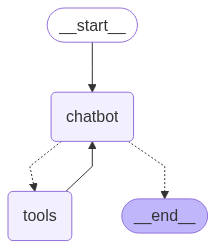

In [51]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
user_input = "LangGraph에서 '노드'란 무엇인가요?"
state = {"messages": [HumanMessage(content=user_input)]}
response = graph.invoke(state)
print(len(response["messages"]))
print(response["messages"][-1].content)

4
LangGraph에서 '노드'는 AI 워크플로우 내의 개별 구성 요소나 에이전트를 나타내는 단위입니다. 노드는 AI 프로세스에서 서로 상호작용하며 특정 작업을 수행하는 "행위자"로 볼 수 있습니다. 예를 들어, 노드는 외부 API를 호출하거나 정보를 처리하는 등의 작업을 수행하는 Python 함수로 정의될 수 있습니다.

노드는 LangGraph에서 중요한 역할을 하며, 각 노드는 그래프의 상태를 입력으로 받아 실행된 후 업데이트된 상태를 반환합니다. 이렇게 노드는 복잡한 관계를 모델링하고 효과적인 의사결정 시스템을 구축할 수 있는 프레임워크를 제공합니다. 노드 간의 연결은 그래프 내의 에저(edge)를 통해 이루어지며, 이는 전반적인 프로세스의 방향성을 제어합니다.

기본적으로, 노드는 간단한 Python 함수에서 복잡한 독립형 에이전트까지 다양할 수 있으며, LangGraph는 노드를 통해 복잡한 AI 에이전트의 워크플로우를 구현할 수 있는 기능을 제공합니다.


In [55]:
for i, message in enumerate(response["messages"]):
    print(f"Message {i}: {message.content}")
    # if hasattr(message, "tool_calls"):
    #     for tool_call in message.tool_calls:
    #         print(f"Tool call: {tool_call['name']}, Args: {tool_call['args']}")

Message 0: LangGraph에서 '노드'란 무엇인가요?
Message 1: 
Message 2: [{"title": "What is LangGraph? - IBM", "url": "https://www.ibm.com/think/topics/langgraph", "content": "Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. Nodes can be thought of as \u201cactors\u201d that interact with each other in a specific way. For example,to add nodes for tool calling, one can use the ToolNode. Another example, the next node, refers to the node that will be executed following the current one. [...] LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Enha